# Exploratory Analysis - Predicting Stock Market Close Prices using LSTM
By Ganel R. Nallamilli

***
## Contents
- **1. Introduction**
    - 1.1 Aims and Purpose
    - 1.2 Imports
    - 1.3 Building the Model
    - 1,4 Helper Functions
- **2. Data Preparation**
    - 2.1 Loading the Data
    - 2.2 Adding Indicators
    - 2.3 Train/Test Split
- **3. Training**
    - 3.1 Training Model
- **4. Results**
    - 4.1 Metrics
    - 4.2 Prediction Graph
    - 4.3 Train/Test Loss Graph
    - 4.4 Learning Rate Graph
    - 4.5 Correlations
- **5. Optimization**
    - 5.1 Bayesian Optimization
- **5. Conclusion**


***

# 1. Introduction
## 1.1 Aims and Purpose
This project aims to see how well LSTMs can predict a stock market close price only using previous-day data. There are multiple articles which use this method to predict stock prices, however, I suspect the output is often misinterpreted. We will only be analysing one timeframe of one stock in this notebook but feel free to change the variables and explore a new stock.

This exploratory analysis is part of my web app project, which provides a user-friendly interface for users to change model parameters and analyse the output. 

## 1.2 Imports

Make sure you install the requirements.txt and import the libraries below.

In [4]:
import yfinance as yf
import torch 
import torch.nn as nn
import pandas as pd
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import math
from torch.autograd import Variable 
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import optuna
import warnings
import json 
warnings.filterwarnings("ignore", category=UserWarning, module=r"torch.optim.lr_scheduler")
torch.manual_seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)

## 1.3 Building the Model

I assume you are already familiar with the LSTM architecture, if you are not please research the basic architecture to aid to understanding - there are  lots of resources online. In this proect we implement the LSTM with pytorch, we then then use fully connected layers to bring our output to a dimensionality of 1 (which is the predicted closing price).

In [5]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn[-1]
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.relu(self.fc_1(out)) #first Dense
        out = self.fc_2(out) 
        return out


## 1.3 Helper Functions
Some useful functions which will help us in this project. We define the function which splits our dataset to train/test and a function which allows us to calculate the corrolation between the previous day features with the closing price.

When splitting the data we scale the data using the minmax scaler for the previous day information, and we use the standard scaler for the target variable (closing prices).

In [6]:
def split_train_test(data,training_split = 0.8):
    data = data.copy()
    X = data
    y = data[['Close']]

    X_lagged = X.iloc[:-1]
    y = y.iloc[1:]

    training_percentage = int(training_split * len(X_lagged))

    features_used = ', '.join(X_lagged.columns)
    num_of_features = len(X_lagged.columns)

    mm = MinMaxScaler()
    ss = StandardScaler()
    X_ss = ss.fit_transform(X_lagged)
    y_mm = mm.fit_transform(y)

    X_train = X_ss[:training_percentage, :]
    X_test = X_ss[training_percentage:, :]

    y_train = y_mm[:training_percentage, :]
    y_test = y_mm[training_percentage:, :] 

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 


    X_train_tensors = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    return X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors,mm,features_used,num_of_features,X_lagged,y,ss

def calculate_correlations(x_clean,y_clean):
    x_clean = x_clean.copy()
    y_clean = y_clean.copy()
    x_clean['next_close'] = y_clean['Close'].to_list()
    correlation_matrix = x_clean.corr()
    correlations_with_single_var = correlation_matrix['next_close'].drop('next_close')
    features = list(correlations_with_single_var.index)
    corrolation_values = list(correlations_with_single_var.values)
    corrolation_values = [abs(x) for x in corrolation_values]
    corrolation_values, features = zip(*sorted(list(zip(corrolation_values,features)),reverse=True))
    return features,corrolation_values


# 2. Data Preparation
## 2.1 Loading the Data

In this analysis we will be looking at google stock 'goog' in the timeframe between '2022-08-02' - '2024-08-02'

In [7]:
# Type ticker and date range you'd like to analyse.
ticker = 'goog'

# year-month-day
start_date = '2015-08-02'
end_date = '2024-08-02'

# Converts the start time to a month earlier as some indictors require past data.
date_obj = datetime.strptime(start_date, '%Y-%m-%d')
one_month_before = date_obj - relativedelta(months=1)
one_month_before_str = one_month_before.strftime('%Y-%m-%d')

# Fetches the stock data. Outputs contains, Open, Close, Volume, Low, High, Adj Close.
data_stock = yf.download(ticker, start=one_month_before_str, end= end_date)


[*********************100%%**********************]  1 of 1 completed


## 2.2 Adding Indicators
In the indicator set we list all the available technical indictors we can add to the data; which we will later train on. Feel free to remove any indicators you don't want the model to train on.

In [8]:
# Indictors you'd like to use in the model
# List of available indicators: '26_ema','21_ema','9_ema','high','low','adj_close','open','volume','upper_bollinger_bands','lower_bollinger_bands', 'macd','signal','SMA20'
indicators = set(['26_ema','21_ema','9_ema','high','low','adj_close','open','volume','upper_bollinger_bands','lower_bollinger_bands', 'macd','signal','SMA20'])


The method below adds all the indicators selected to the stock dataframe.

In [9]:
# Adds indicators to the dataframe.
if 'macd' in indicators or 'signal' in indicators:
    data_stock['EMA12'] = data_stock['Close'].ewm(span=12, adjust=False).mean()
    data_stock['EMA26'] = data_stock['Close'].ewm(span=26, adjust=False).mean()
    data_stock['MACD'] = data_stock['EMA12'] - data_stock['EMA26']
    data_stock['Signal Line'] = data_stock['MACD'].ewm(span=9, adjust=False).mean()
    data_stock = data_stock.drop(columns = ['EMA12','EMA26'])
if 'MACD' in data_stock and 'macd' not in indicators:
    data_stock = data_stock.drop(columns = ['MACD'])
if 'Signal Line' in data_stock and 'signal' not in indicators:
    data_stock = data_stock.drop(columns = ['Signal Line'])
if '26_ema' in indicators:
    data_stock['26 EMA'] = data_stock['Close'].ewm(span=26, adjust=False).mean()
if '21_ema' in indicators:
    data_stock['21 EMA'] = data_stock['Close'].ewm(span=21, adjust=False).mean()
if '9_ema' in indicators:
    data_stock['9 EMA'] = data_stock['Close'].ewm(span=9, adjust=False).mean()
if 'upper_bollinger_bands' in indicators or 'lower_bollinger_bands' in indicators:
    data_stock['SMA20'] = data_stock['Close'].rolling(window=20).mean()
    data_stock['SD20'] = data_stock['Close'].rolling(window=20).std()
    data_stock['Upper Bollinger Band'] = data_stock['SMA20'] + 2 * data_stock['SD20']
    data_stock['Lower Bollinger Band'] = data_stock['SMA20'] - 2 * data_stock['SD20']
    data_stock = data_stock.drop(columns = ['SMA20','SD20'])
if 'Upper Bollinger Band' in data_stock and 'upper_bollinger_bands' not in indicators:
    data_stock = data_stock.drop(columns = ['Upper Bollinger Band'])
if 'Lower Bollinger Band' in data_stock and 'lower_bollinger_bands' not in indicators:
    data_stock = data_stock.drop(columns = ['Lower Bollinger Band'])
if 'SMA20' in indicators:
    data_stock['20 SMA'] = data_stock['Close'].rolling(window=20).mean()
if 'high' not in indicators:
    data_stock = data_stock.drop(columns = ['High'])
if 'low' not in indicators:
    data_stock = data_stock.drop(columns = ['Low'])
if 'adj_close' not in indicators:
    data_stock = data_stock.drop(columns = ['Adj Close'])
if 'volume' not in indicators:
        data_stock = data_stock.drop(columns = ['Volume'])
if 'open' not in indicators:
    data_stock = data_stock.drop(columns = ['Open'])

#Drops any columns with NaNs.
data_stock = data_stock.dropna()

#Filters data such that it only contains data from the start date.
start_date_obj = pd.to_datetime(start_date)
data_stock = data_stock[data_stock.index >= start_date_obj]

We can now look at the dataframe, and we see all the indicators have been added.

In [10]:
data_stock

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,26 EMA,21 EMA,9 EMA,Upper Bollinger Band,Lower Bollinger Band,20 SMA
Date,,,,,,,,,,,,,,
2015-08-03,31.267000,31.652800,31.267000,31.560499,31.524626,26090000,1.292643,1.356936,29.846264,30.265046,31.386626,35.481046,24.744804,30.112925
2015-08-04,31.421000,31.740499,31.358000,31.462500,31.426737,29818000,1.222705,1.330090,29.965985,30.373906,31.401801,35.450348,25.296652,30.373500
2015-08-05,31.716499,32.393002,31.658001,32.188999,32.152412,46686000,1.211931,1.306458,30.130653,30.538914,31.559240,35.351365,26.030385,30.690875
2015-08-06,32.250000,32.268951,31.612499,32.133999,32.097473,31452000,1.185291,1.282225,30.279049,30.683922,31.674192,35.143327,26.848423,30.995875
2015-08-07,32.011501,32.133999,31.485500,31.764999,31.728893,28078000,1.121476,1.250075,30.389119,30.782202,31.692353,34.835358,27.682241,31.258800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,168.770004,169.839996,165.865005,168.679993,168.679993,25150100,-1.972672,0.433845,180.707774,180.589781,177.216561,197.332859,170.228142,183.780501
2024-07-29,170.500000,172.160004,169.720001,171.130005,171.130005,13768900,-2.433223,-0.139569,179.998310,179.729802,175.999250,197.854116,168.477886,183.166001
2024-07-30,171.830002,172.949997,170.119995,171.860001,171.860001,13681400,-2.708091,-0.653273,179.395472,179.014365,175.171400,198.045890,167.023112,182.534501


## 2.3 Train/Test Split
Now we have a dataset, we split our data into training and testing...

In [11]:
training_split = 0.8
X_train, y_train, X_test, y_test,scaler,features_used,num_of_features,x_clean,y_clean,data_scaler = split_train_test(data_stock, training_split = training_split)


# 3. Training
## 3.1 Training Model 
Here we set the hyperparameters for our model, these metrics may need to be changed and refined, however, the optimal hyperparameters can be found during Bayesian optimization later. 

**learning_rate** - Learning rate of the model

**num_epochs** - Maximum number of epochs used in training

**patience** - The number of epochs allowed to be trained without improvement in the test loss before training stops (relates to preventing overfitting)

**ReduceLROnPlateau_factor** - The factor the scheduler reduces the learning rate by

**ReduceLROnPlateau_patience** - The number of epochs without improvement of the test loss before the scheduler decreases the learning rate

**hidden_size** - Hidden size of the LSTM model

**num_layers** - Number of stacked LSTMs used, if more than 1 you may want to introduce a dropout parameter.

In [12]:
learning_rate = 0.00001
num_epochs = 100000
patience = 100
ReduceLROnPlateau_factor = 0.9
ReduceLROnPlateau_patience = 10

hidden_size = 75 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

The code below trains the model... if you are happy with the hyperparameters above run the code below

In [13]:
input_size = num_of_features #number of features (Do not change)
num_classes = 1 #number of output classes (Do not change)
model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=ReduceLROnPlateau_factor, patience=ReduceLROnPlateau_patience)
patience = patience

train_loss_array = []
test_loss_array = []
learning_rates = []
models = []
epochs_with_no_improvements = 0
best_loss = float('infinity')
best_model = None
epoch_tqdm = tqdm(range(num_epochs))

for epoch in epoch_tqdm:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train) #forward pass
    
    # obtain the loss function
    loss = criterion(outputs, y_train)
    
    loss.backward() #calculates the loss of the loss function
    
    optimizer.step() #improve from loss, i.e backprop
    train_loss_array.append(loss.item())
    models.append(model)

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        loss_test = criterion(y_test_pred, y_test)
        test_loss_array.append(loss_test.item())

    scheduler.step(loss_test)


    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    epoch_tqdm.set_postfix(test_loss=float(loss_test.item()),train_loss=float(loss.item()), no_improvement = epochs_with_no_improvements)

    if loss_test < best_loss:
        best_loss = loss_test
        epochs_with_no_improvements = 0
        best_model = model
    else:
        epochs_with_no_improvements += 1


    if epochs_with_no_improvements == patience:
        break

    model.train()

  0%|          | 0/100000 [00:00<?, ?it/s]

# 4. Results

Now the model is trained we can now inspect the performance of our trained model. We need to extract the predicted close price from the model by feeding in data and converting the output back to the unscaled close price values so we can compare it to the true close price values.

In [14]:
best_model.eval()
with torch.no_grad():
    test_y_pred = best_model(X_test)
    train_x_pred = best_model(X_train)

true_pred_close_test = scaler.inverse_transform(test_y_pred)
y_test_unscaled = scaler.inverse_transform(y_test)
true_pred_close_train = scaler.inverse_transform(train_x_pred)

y_axis_close_test = list(true_pred_close_test.flatten())
y_axis_close_train = list(true_pred_close_train.flatten())

## 4.1 Metrics
We use the RMSE (can be interpreted as the average error difference from the true closing price and the predicted closing price) and r^2 values (which tells us about how well the model captures the variance of the close prices) to judge the performance of the model. We compare these values to a Naive model, which is siimply using 'yesterdays closing price as todays predicted closing price'.

In [15]:
RMSE = round(math.sqrt(metrics.mean_squared_error(y_test_unscaled.flatten(), true_pred_close_test.flatten())),5)
RMSE_naive = round(math.sqrt(metrics.mean_squared_error(y_test_unscaled.flatten(), list(data_stock['Close'].iloc[:-1])[len(true_pred_close_train):])),5)
r_squared = round(metrics.r2_score(y_test_unscaled.flatten(), true_pred_close_test.flatten()), 5)
r_squared_naive = round(metrics.r2_score(y_test_unscaled.flatten(), list(data_stock['Close'].iloc[:-1])[len(true_pred_close_train):]), 5)
print(f'RMSE: {RMSE} | Naive RMSE: {RMSE_naive}')
print(f'r^2: {r_squared} | Naive r^2: {r_squared_naive}')

RMSE: 3.29563 | Naive RMSE: 2.49303
r^2: 0.98589 | Naive r^2: 0.99193


We see that our model has not been able to outperform the naive model.

## 4.2 Prediction Graph

We now plot the predicted close prices against the true close price. The Naive model is plotted for comparison.

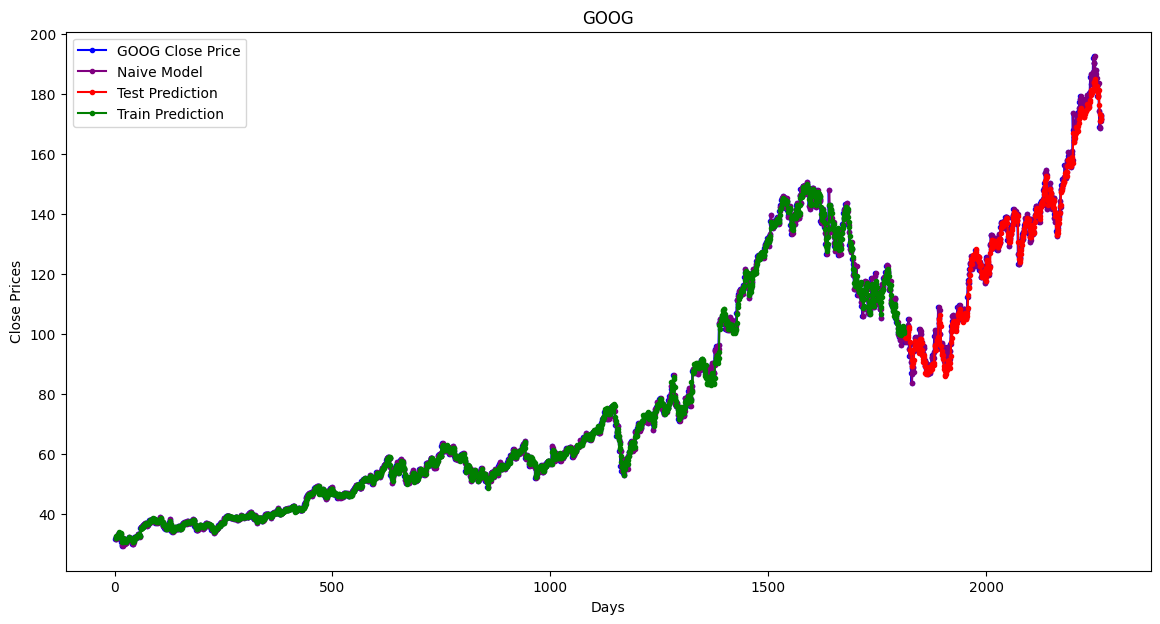

In [16]:
dates = [x.strftime('%d-%m-%Y') for x in data_stock.index]
days_number = [i+1 for i in range(len(dates))]
plt.figure(figsize =(14,7))
plt.plot(days_number,data_stock['Close'], label =f'{ticker.upper()} Close Price', marker = '.', color = 'blue')
plt.plot(days_number[1:],list(data_stock['Close'].iloc[:-1]), label =f'Naive Model', marker = '.', color = 'purple')
plt.plot(days_number[len(y_axis_close_train)+1:],y_axis_close_test, label =f'Test Prediction', marker = '.', color = 'red')
plt.plot(days_number[1:len(y_axis_close_train)+1],y_axis_close_train, label =f'Train Prediction', marker = '.', color = 'green')
plt.ylabel('Close Prices')
plt.xlabel('Days')
plt.title(ticker.upper())
plt.legend()
plt.show()

From the graph, it looks like our model can accurately predict the close prices, however we know that from our metrics we know the model cannot beat the naive model. Lets take a closer look into the test data...

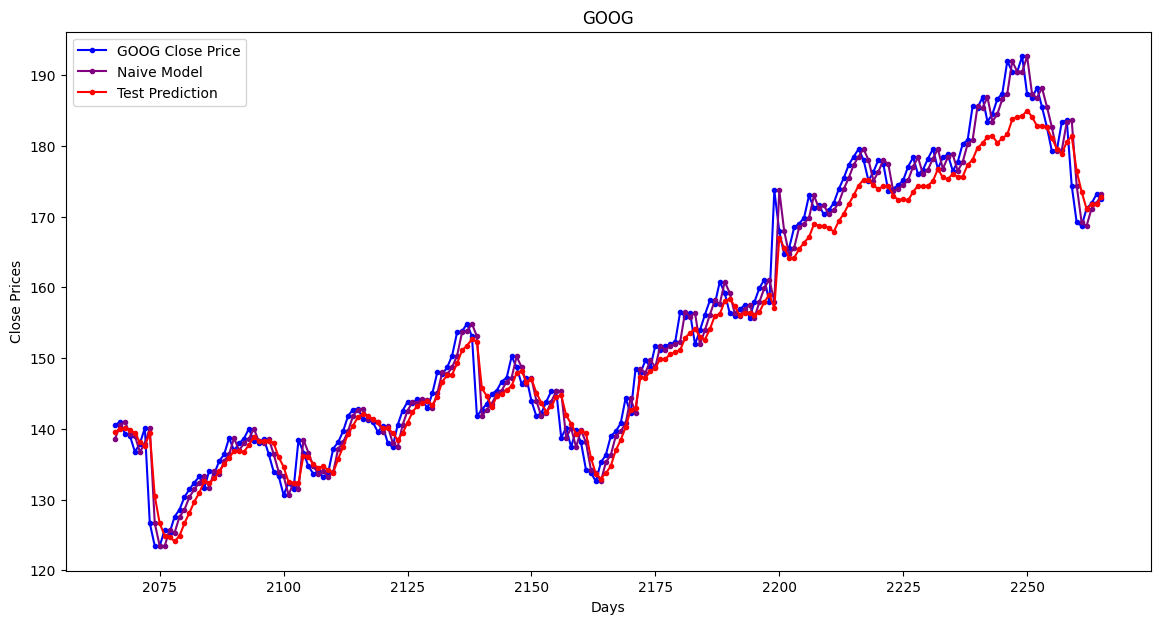

In [17]:
days_number = [i+1 for i in range(len(dates))]
truncate = -200
plt.figure(figsize =(14,7))
plt.plot(days_number[len(y_axis_close_train)+1:][truncate:],data_stock['Close'].iloc[len(y_axis_close_train)+1:][truncate:], label =f'{ticker.upper()} Close Price', marker = '.', color = 'blue')
plt.plot(days_number[1:][len(y_axis_close_train)+1:][truncate:],list(data_stock['Close'].iloc[:-1])[len(y_axis_close_train)+1:][truncate:], label =f'Naive Model', marker = '.', color = 'purple')
plt.plot(days_number[len(y_axis_close_train)+1:][truncate:],y_axis_close_test[truncate:], label =f'Test Prediction', marker = '.', color = 'red')
plt.ylabel('Close Prices')
plt.xlabel('Days')
plt.title(ticker.upper())
plt.legend()
plt.show()

We see that or model generally picks up the trends in the close prices however is unable to make accurate predictions. Moreover, a more important detail to notice is that the model seems to lag behind by one day. We see that the predicted close prices closely mimics the previous day closing price rather than establishing a new trend based off the available information. This suggests that the previous day price, contains no deeper information to help predict future closing prices.

## 4.3 Train/Test Loss Graph

An important graph to look at when training a model is the train/test loss curves as it gives us an insight into if the model has finished training, and if any overfitting as occured.

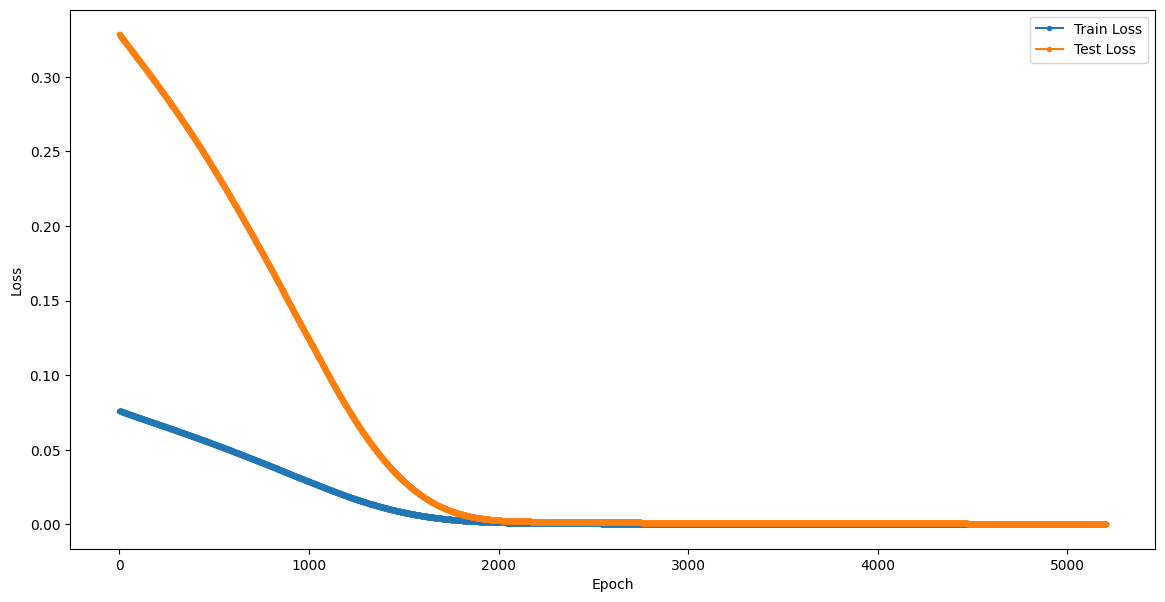

In [329]:
plt.figure(figsize =(14,7))
plt.plot(train_loss_array, label = 'Train Loss', marker = '.')
plt.plot(test_loss_array, label = 'Test Loss', marker = '.')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

From the graph, we observe that both losses plateau at a similar value. This indicates that the model has likely found a minimum that effectively reduces both the training and testing losses to a comparable level and is generally an indicator that the training process is complete.

## 4.4 Learning Rate Graph

We can also view how the learning rate changes throughout training...

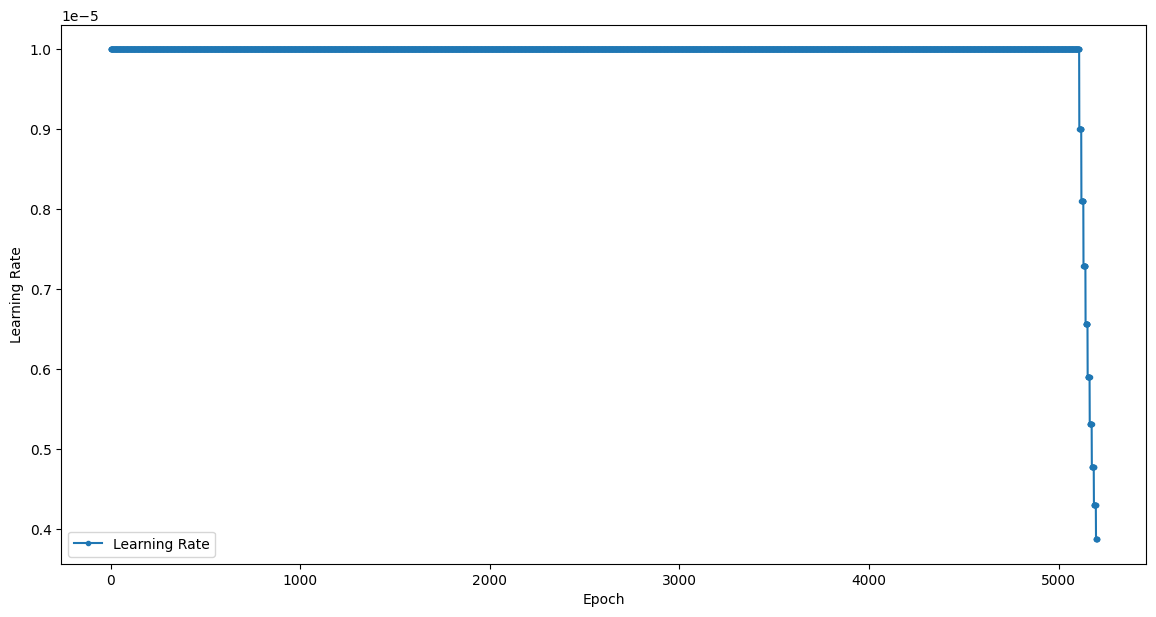

In [330]:
plt.figure(figsize =(14,7))
plt.plot(learning_rates, label = 'Learning Rate', marker = '.')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 4.5 Correlations

Looking at corrolations between the input and target variables can also improve our model further. Generally if we see many varibles which don't corrolate well with the target variable, it may confuse the model and increase training times.

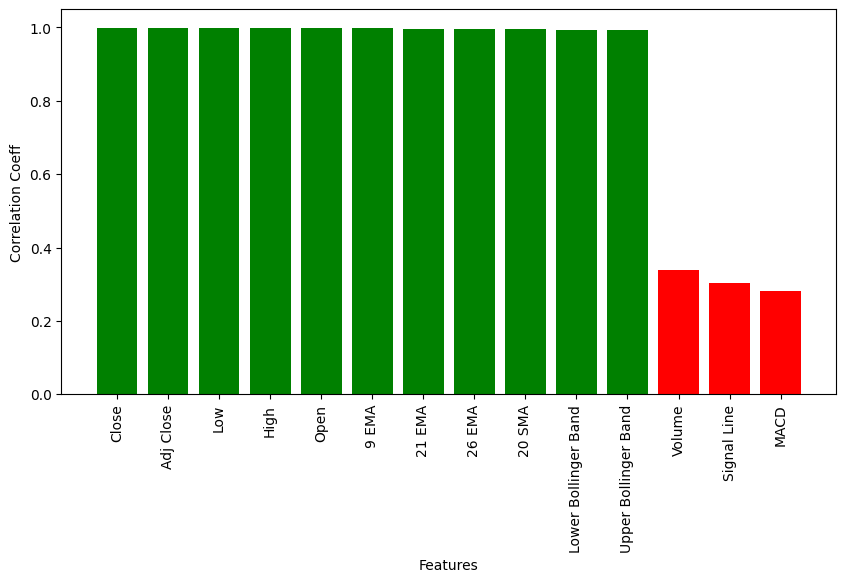

In [331]:
corro_features,corrolation_values = calculate_correlations(x_clean,y_clean)
corro_colours = ['green' if x>0.5 else 'red' for x in corrolation_values]
plt.figure(figsize = (10,5))
plt.bar(corro_features,corrolation_values,color=corro_colours)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Correlation Coeff')
plt.show()

In the future, it may be worth not including the volume, signal line and MACD due to them not being highly corrolated with the next day closing price.

# 5. Optimization
## 5.1 Bayesian Optimization
The final step is to optimize all the hyperparameters of the model - we use bayesian optimization to do this...

In [256]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0000001,0.000001)
    hidden_size = trial.suggest_int('hidden_size', 16,50)
    ReduceLROnPlateau_factor = trial.suggest_float('factor', 0.01, 0.99)
    ReduceLROnPlateau_patience = trial.suggest_int('patience', 1,200)

    num_epochs = 100000
    training_split = 0.8
    X_train, y_train, X_test, y_test,scaler,features_used,num_of_features,x_clean,y_clean,data_scaler = split_train_test(data_stock, training_split = training_split)
    
    input_size = num_of_features #number of features
    num_layers = 1 #number of stacked lstm layers
    num_classes = 1 #number of output classes 
    
    model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1])
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=ReduceLROnPlateau_factor, patience=ReduceLROnPlateau_patience)
    
    patience = 50
    
    train_loss_array = []
    test_loss_array = []
    learning_rates = []
    models = []
    epochs_with_no_improvements = 0
    best_loss = float('infinity')
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train) #forward pass
        
        # obtain the loss function
        loss = criterion(outputs, y_train)
        
        loss.backward() #calculates the loss of the loss function
        
        optimizer.step() #improve from loss, i.e backprop
        train_loss_array.append(loss.item())
        models.append(model)
    
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            loss_test = criterion(y_test_pred, y_test)
            test_loss_array.append(loss_test.item())
    
        scheduler.step(loss_test)
    
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
    
    
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_with_no_improvements = 0
            best_model = model
        else:
            epochs_with_no_improvements += 1
    
    
        if epochs_with_no_improvements == patience:
            break
    
        model.train()
    return loss_test.item()
    
    
    
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on your objective
study.optimize(objective, n_trials=300)


[I 2024-08-11 16:48:58,287] A new study created in memory with name: no-name-3f411404-9b3b-468f-b6d7-03b129a783bd
[W 2024-08-11 16:58:41,760] Trial 0 failed with parameters: {'learning_rate': 3.6705048638744183e-07, 'hidden_size': 36, 'factor': 0.2054996409673606, 'patience': 131} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\UserFiles\Projects\stock_market_model_lstm\lstm_env\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "D:\TEMP\ipykernel_31296\3126926359.py", line 33, in objective
    outputs = model(X_train) #forward pass
  File "D:\UserFiles\Projects\stock_market_model_lstm\lstm_env\lib\site-packages\torch\nn\modules\module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "D:\UserFiles\Projects\stock_market_model_lstm\lstm_env\lib\site-packages\torch\nn\modules\module.py", line 1562, in _call_impl
    return forward_call(*arg

KeyboardInterrupt: 

Below prints the best hyperparameters, we can now use these parameters above...

In [247]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 2.4655608761503274e-05, 'hidden_size': 21, 'factor': 0.5898498652466889, 'patience': 133}


# 5. Conclusion

As mentioned earlier, although the model seems to visually be able to predict the market, looking closer at the graph we see that the trends it predicts are lagged by a day. This supports the efficent market hypothesis that asset prices reflect all available information, and therefore the model cannot predict future closing prices based off previous asset prices, or any other variables derived from asset prices such as the technical indicators used in this analysis.

Moreover, variables do not directly have an upper limit which means the scaling method chosen to scale variables in the analysis may not be suitable over long term. In addition to this, the variance of closing prices is not stationary which the LSTM may not be able to handle.

## Future Improvements

In the future, it may be worth adding fundamental analysis features such as news sentiment headlines or macroeconomic features such as unemployment rate, inflation rate, ect ... This may increase the performance of the model as the model may be able to predict closing prices based off information which the market has not reacted to yet. We could also adjust the use case of the model, by only using it in periods of low volatility such that the market is more predictable.